### Homework 3:  Regression Challenge

Your homework assignment will be to synthesize the lessons taught in Unit 3, and present a coherent walk through of how you approached the modeling process.

**What You Will Turn In:**

A jupyter notebook with code and commentary that walks us through the following:

 - Exploratory Data Analysis on the original data
   - What are general patterns within the target variable? 
   - What relationships can we deduce from the features in X and how they relate to one another?  How they impact y?
   
 - What were some of the challenges in dealing with this dataset and why?
 - What cross validation strategy did you use and why?
   - How did you interpret their results?
   - What did you change as a result?
   - Did changing the number of folds have any measurable impact on your scores?
 - The use of pipelines to streamline your data processing and ensure correct alignment between training and test sets
 - Strategies you used to try and improve your score (it's okay if they didn't work -- just show us what you tried to do and why)
 - What features ended up having important causal impact on the target variable?  Can you demonstrate this graphically?
 - How did you choose your model parameters?
 - How did you validation predictions compare with your test set predictions?  Can you visualize this graphically?
  
The end result should be a coherent walk through of how you approached the problem and developed a coherent solution to model your data.

Some bonus tasks you could take on:  

 - The `bikeshare` dataset makes use of a date column.  There are many specialized versions of KFold, one of which is Time Series Splitting.  This would split the data in a way that was described in the cross-validation class, with each validation set coming after the previous training sets.  Could you make use of this in your modeling?  You can find it here:  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [136]:
import pandas as pd
import numpy as np
import category_encoders as ce

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from pdpbox import pdp, info_plots
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
#Loading data
df = pd.read_csv('data/bikeshare.csv',parse_dates=['datetime'])

In [81]:
#extract features
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')

In [82]:
df.rename(columns={'count':'totalbikes'}, inplace=True)

In [84]:
df['hour'] = df.datetime.dt.hour
df['day'] = df.datetime.dt.day
df['month'] = df.datetime.dt.month
df['year'] = df.datetime.dt.year

In [85]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'totalbikes', 'hour', 'day', 'month',
       'year'],
      dtype='object')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  object        
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  object        
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   totalbikes  10886 non-null  int64         
 10  hour        10886 non-null  int64         
 11  day         10886 non-null  int64         
 12  month       10886 non-null  int64         
 13  year        10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8), object(2)
memory usage: 1.2+ MB


In [ ]:
df = df.sort_values(by='datetime',ascending=True)

In [ ]:
df.set_index('datetime', inplace=True)
df

In [100]:
df.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
totalbikes    0
hour          0
day           0
month         0
year          0
dtype: int64

In [101]:
df.temp.value_counts().sort_index()

0.82       7
1.64       2
2.46       5
3.28      11
4.10      44
4.92      60
5.74     107
6.56     146
7.38     106
8.20     229
9.02     248
9.84     294
10.66    332
11.48    181
12.30    385
13.12    356
13.94    413
14.76    467
15.58    255
16.40    400
17.22    356
18.04    328
18.86    406
19.68    170
20.50    327
21.32    362
22.14    403
22.96    395
23.78    203
24.60    390
25.42    403
26.24    453
27.06    394
27.88    224
28.70    427
29.52    353
30.34    299
31.16    242
31.98     98
32.80    202
33.62    130
34.44     80
35.26     76
36.08     23
36.90     46
37.72     34
38.54      7
39.36      6
41.00      1
Name: temp, dtype: int64

In [102]:
# useful function to help denote missing values
def denote_null_values(df):
    empty_cols_query = df.isnull().sum() > 0
    empty_df_cols = df.loc[:, empty_cols_query].columns.tolist()
    for col in empty_df_cols:
        col_name = f"{col}_missing"
        df[col_name] = pd.isnull(df[col])
    return df

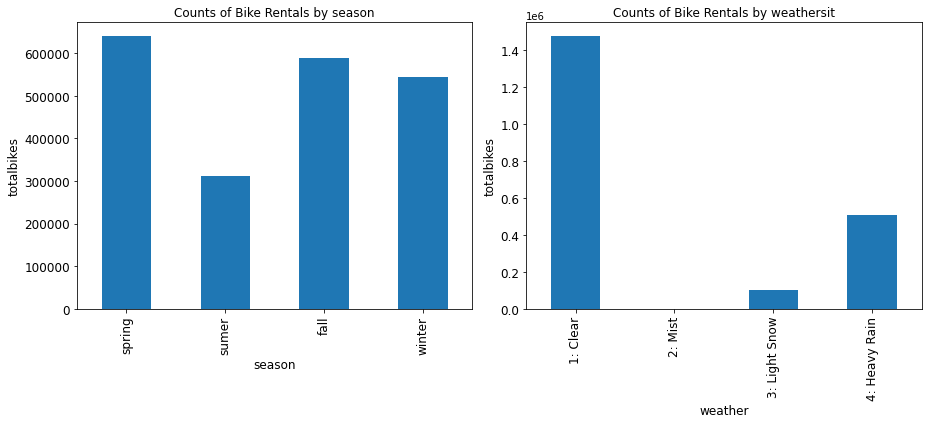

In [141]:
# data visualization

f,  (ax1, ax2)  =  plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

ax1 = df[['season','totalbikes']].groupby(['season']).sum().reset_index().plot(kind='bar',
                                       legend = False, title ="Counts of Bike Rentals by season", 
                                         stacked=True, fontsize=12, ax=ax1)
ax1.set_xlabel("season", fontsize=12)
ax1.set_ylabel("totalbikes", fontsize=12)
ax1.set_xticklabels(['spring','sumer','fall','winter'])

 
ax2 = df[['weather','totalbikes']].groupby(['weather']).sum().reset_index().plot(kind='bar',  
      legend = False, stacked=True, title ="Counts of Bike Rentals by Weather", fontsize=12, ax=ax2)

ax2.set_xlabel("weather", fontsize=12)
ax2.set_ylabel("totalbikes", fontsize=12)
ax2.set_xticklabels(['1: Clear','2: Mist','3: Light Snow','4: Heavy Rain'])

f.tight_layout()

In [142]:
## bike rentals increase in clear weather
## rentals decrease in Summer (humididity/temp?)

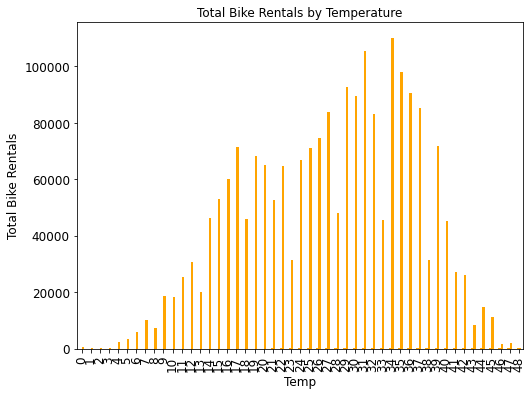

In [144]:
ax = df[['temp','totalbikes']].groupby(['temp']).sum().reset_index().plot(kind='bar', figsize=(8, 6),
                                       legend = False, title ="Total Bike Rentals by Temperature", 
                                       color='orange', fontsize=12)
ax.set_xlabel("Temp", fontsize=12)
ax.set_ylabel("Total Bike Rentals", fontsize=12)
plt.show()

In [95]:
#variables (dropping the ones I added initially to gte baseline score)
y = df['totalbikes']
X = df.drop(['hour','day','month','year','totalbikes'], axis=1)

In [96]:
#Train, test, and val data
#60% - train set
#20% - validation set
#20% - test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2

In [97]:
# create a pipeline, and get our model score
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())

# fit & score
pipe.fit(X_train, y_train)
print('Baseline Score=')
pipe.score(X_val, y_val)

Baseline Score=


0.3354963593971615

In [99]:
#added features day, month, year, and hour to variables
y = df['totalbikes']
X = df.drop('totalbikes', axis=1)

#Train, test, and val data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2

# create a pipeline, and get our model score
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())

# fit & score
pipe.fit(X_train, y_train)
print('Round 1 Score=')
pipe.score(X_val, y_val)


Round 1 Score=


0.8599608042673106

In [ ]:
# trying to shift
df_shift = df['datetime'].groupby(['datetime','hour']).sum().reset_index()
df_shift.sort_values(['datetime','hour'])
# shift the count of the last two hours forward so the new count can take in consideratio how the last two hours went 
df_shift['sum_hr_shift_1'] = bikes_hour_df_shift.cnt.shift(+1)
df_shift['sum_hr_shift_2'] = bikes_hour_df_shift.cnt.shift(+2)

bike_df_model_ready =  pd.merge(bikes_hour_df, bikes_hour_df_shift[['dteday', 'hr', 'sum_hr_shift_1', 'sum_hr_shift_2']], how='inner', on = ['dteday', 'hr'])

# drop NAs caused by our shifting fields around
bike_df_model_ready = bike_df_model_ready.dropna()

outcome = 'totalbikes'
# create a feature list for each modeling - experiment by adding features to the exclusion list
features = [feat for feat in list(bike_df_model_ready) if feat not in [outcome, 'instant', 'dteday','casual', 'registered']]  

#Train, test, and val data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2


gbr = GradientBoostingRegressor()
gbr.fit(X_train, np.ravel(y_train))
predictions = gbr.predict(X_test)

y = df['totalbikes']
X = df.drop('totalbikes', axis=1)

# create a pipeline, and get our model score
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())

# fit & score
pipe.fit(X_train, y_train)
print('Round 1 Score=')
pipe.score(X_val, y_val)



In [106]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('targetencoder', TargetEncoder(cols=['season', 'weather'])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [113]:
transformed_X = pipe[0].transform(X_train)

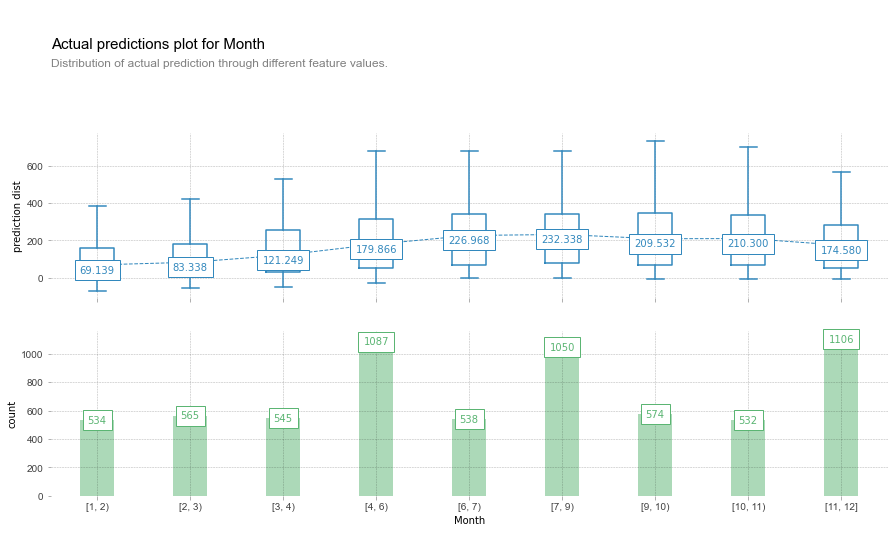

In [116]:
# this chart summarizes the model predictions made for each unique value for each month
fig, axes, summary_df = info_plots.actual_plot(
    model=pipe[1], X=transformed_X, 
    feature='month', feature_name='Month', predict_kwds={}
)

In [117]:
summary_df

,x,display_column,value_lower,value_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[1, 2)",1.0,2.0,534,9.850265,69.139001,159.616054
1,1,"[2, 3)",2.0,3.0,565,18.508393,83.338029,180.875626
2,2,"[3, 4)",3.0,4.0,545,32.372939,121.248509,254.782287
3,3,"[4, 6)",4.0,6.0,1087,49.941189,179.865526,317.070036
4,4,"[6, 7)",6.0,7.0,538,70.198731,226.968056,344.605296
5,5,"[7, 9)",7.0,9.0,1050,76.819055,232.338194,342.681025
6,6,"[9, 10)",9.0,10.0,574,70.756201,209.532174,345.741523
7,7,"[10, 11)",10.0,11.0,532,67.833789,210.299792,334.005232
8,8,"[11, 12]",11.0,12.0,1106,52.113204,174.579655,280.523546


In [131]:
# genre cols - season
#season_cols = [col for col in pipe[0].get_feature_names()]
#season_cols

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'hour',
 'day',
 'month',
 'year']

In [ ]:
# genre cols - weather
#weather_cols = [col for col in pipe[0].get_feature_names('weather')]
#city_cols

#only use with one hot encoding

In [132]:
# and what about interactions?
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=pipe[0], X=transformed_X, 
    features=['month', 'year'], 
    feature_names=['Month', 'Year']
)

axes['value_ax'].set_xticklabels(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

AttributeError: 'TargetEncoder' object has no attribute 'predict'

In [134]:
regressor = RandomForestRegressor()
parameters = [{'n_estimators' : [150,200,250,300], 'max_features' : ['auto','sqrt','log2']}]
grid_search = GridSearchCV(estimator = regressor, param_grid = parameters)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

NameError: name 'GridSearchCV' is not defined

**Datasets You Can Work With:**

`bikeshare.csv` **intermediate difficulty** -- this is the dataset that was part of your bonus assignment.  It represents the number of bike rentals every hour in Manhattan during the course of several years.  This dataset is a **time series**, so it's important to make judicious use of time-based data, and to make sure you cross-validate your results sequentially.

  - datetime: a timestamp collected hourly.
  - season: a categorical column that lists the current season for that observation
  - holiday: a column (0 or 1), that detects whether or not it was a holiday
  - workingday: a column (0 or 1), that encodes whether or not it was a workday or not
  - weather: a categorical column that lists a light weather description for the observation
  - temp: the temperature outside
  - atemp: the temperature it feels like outside
  - humidity: the humidity outside
  - windspeed: the windspeed, in mph
  - count: the number of bikes checked out during that hour
  